In [5]:
import sys
import os
p = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(p, '..')))
sys.path

['/home/powell/work/insight/focal/notebooks',
 '/home/powell/work/insight/bablu/deps/models/research',
 '/home/powell/work/insight/bablu/deps/models/research/slim',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/pycocotools-2.0-py3.6-linux-x86_64.egg',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/IPython/extensions',
 '/home/powell/.ipython',
 '/home/powell/work/insight/focal',
 '/home/powell/work/insight',
 '/home/powell/work/insight/focal']

In [6]:
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from pipeline.unet_model import unet

## Load the data

load the grayscale images and masks for train and test sets

In [8]:
UNET_OUTPUT_TRAIN_DIR='/mnt/data/portrait_indoor_unet/train'
UNET_OUTPUT_TEST_DIR='/mnt/data/portrait_indoor_unet/test'
IMAGES_DIR='images'
MASKS_DIR='masks'

In [9]:
def normalize_img(img):
    img = img / 255
    return img

def mask_encode(a, nb_classes=2):
    targets = np.array(a).reshape(-1)
    one_hot_targets = np.eye(nb_classes)[targets]
    return one_hot_targets.reshape(list(a.shape) + [-1])
    
def normalize_mask(mask_img):
    #mask_img = mask_img / 255
    #mask_img[mask_img > 0.5] = 1
    #mask_img[mask_img <= 0.5] = 0
    #return mask_encode(mask_img.astype('uint8'))
    return mask_img.astype('uint8')

def normalize_img_mask(img, mask_img):
    #print('img shape: {}, mask shape: {}'.format(img.shape, mask_img.shape))
    return normalize_img(img), normalize_mask(mask_img)

def getImagesCount(base_path, d, image_suffix='jpg'):
    return len(glob.glob(os.path.join(base_path,"{}/*.{}".format(d, image_suffix))))

def getImagesAndMasks(base_path, image_prefix='images', masks_prefix='masks', 
                      image_suffix='jpg', mask_suffix='png',
                      verify_shape=(256,256,1), count_max=None):
    image_paths = glob.glob(os.path.join(base_path,"{}/*.{}".format(image_prefix, image_suffix)))
    masks_paths = [os.path.join(os.path.join(base_path, masks_prefix), 
                                '{}.{}'.format(os.path.basename(x).split('.')[0], mask_suffix)) for x in image_paths] 

    if count_max is not None:
        image_paths = image_paths[0:count_max]
        masks_paths = masks_paths[0:count_max]
        
    images_ret = np.array([normalize_img(cv2.imread(x, cv2.IMREAD_GRAYSCALE)).reshape(256, 256, 1) for x in image_paths])
    masks_ret = np.array([normalize_mask(cv2.imread(x, cv2.IMREAD_GRAYSCALE)).reshape(256, 256, 1) for x in masks_paths])
    return images_ret, masks_ret

def trainGenerator(base_path, batch_size, images_folder='images', masks_folder='masks', aug_dict=None,
                   color_mode = 'grayscale', num_class = 2, target_size = (256,256), seed = 42):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        base_path,
        classes = [images_folder],
        class_mode = None,
        color_mode = color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        base_path,
        classes = [masks_folder],
        class_mode = None,
        color_mode = color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = normalize_img_mask(img, mask)
        yield (img,mask)


In [10]:
BATCH_SIZE=16

In [11]:
train_count = getImagesCount(base_path=UNET_OUTPUT_TRAIN_DIR, d='images', image_suffix='jpg')
train_gen = trainGenerator(base_path=UNET_OUTPUT_TRAIN_DIR, batch_size=BATCH_SIZE)
print('Total image count: {}'.format(train_count))

Total image count: 131900


In [12]:
X_test, y_test = getImagesAndMasks(base_path=UNET_OUTPUT_TEST_DIR)
print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))

X_test shape: (33000, 256, 256, 1), y_test shape: (33000, 256, 256, 1)


In [9]:
#X_train, y_train = getImagesAndMasks(base_path=UNET_OUTPUT_TRAIN_DIR, count_max=2000)
#print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))

In [10]:
model = unet()
model_checkpoint = ModelCheckpoint('../pretrained_models/unet_model/unet_focal-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
________________________________________________________________________

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_count/BATCH_SIZE,
                              epochs=6,
                              validation_data=(X_test, y_test), shuffle=True, 
                              callbacks=[model_checkpoint])

Epoch 1/6
Found 131900 images belonging to 1 classes.
Found 131900 images belonging to 1 classes.
8244/8243 [==============================] - 4781s 580ms/step - loss: 0.0530 - _mean_iou_unet_wrapper: 0.9504 - val_loss: 0.0896 - val__mean_iou_unet_wrapper: 0.9399

Epoch 00001: saving model to ../pretrained_models/unet_model/unet_focal-01-0.09.hdf5
Epoch 2/6
8243/8243 [============================>.] - ETA: 0s - loss: 0.0172 - _mean_iou_unet_wrapper: 0.9819

In [ ]:
#history = model.fit(X_train, y_train,
#                    batch_size=BATCH_SIZE,
#                    epochs=3,
#                    validation_data=(X_test, y_test), shuffle=True, 
#                    callbacks=[model_checkpoint])

In [ ]:
y_pred = model.predict(np.array([X_test[0]]))

In [ ]:
from __future__ import print_function
from keras import backend as K
import tensorflow as tf

def _simple_iou_test(y_true, y_pred):
    iou = []
    for i in range(0, 2):
        true_labels = K.equal(y_true, i)
        pred_labels = K.equal(y_pred, i)
        union = tf.to_int32(pred_labels | true_labels)
        inter = tf.to_int32(pred_labels & true_labels)
        union_sum = K.sum(K.sum(union, axis=1), axis=1)
        inter_sum = K.sum(K.sum(inter, axis=1), axis=1)
        ious = inter_sum / union_sum
        legal_batches = K.sum(K.sum(tf.to_int32(true_labels), axis=1), axis=1)>0
        print('class {}: legal batches shape: {}, legal batches: {}'.format(i, legal_batches.shape,
                                                                  legal_batches.eval()))
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches))))
        #print('union sum: {}'.format(union_sum.eval()))
        #print('inter sum: {}'.format(inter_sum.eval()))
        #print('ious {}'.format(ious.eval()))
        #print('mean: {}'.format(K.sum(ious).eval()))
    iou = tf.stack(iou)
    #legal_labels = ~tf.debugging.is_nan(ious)
    #ious_non_nans = tf.where(legal_labels, ious, 
    #                         tf.zeros_like(ious))
    #print('ious_non_nans sum shape: {}'.format(ious_non_nans.eval().shape))
    #print('ious_non_nans sum: {}'.format(K.sum(ious_non_nans).eval()))
    #return K.mean(ious_non_nans)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

def _mean_iou_unet_wrapper_test(y_true, y_pred):
    y_pred_thresh = tf.to_int32(y_pred > 0.5)

    y_true_reshaped = tf.reshape(y_true,
                                 tf.shape(y_true)[:-1])

    y_pred_reshaped = tf.reshape(y_pred_thresh,
                                 tf.shape(y_pred_thresh)[:-1])
    return _simple_iou_test(y_true_reshaped, y_pred_reshaped)

sess = tf.InteractiveSession()
#y_true = tf.convert_to_tensor(np.array([y_test[0]]), np.int32)
#iou = _mean_iou_unet_wrapper_test(y_true, y_pred)
#print(iou.eval())

yt = tf.convert_to_tensor(np.array([np.ones((256, 256, 1))]))
b = np.ones((256, 256))
b[128:, :] = 0
yp = tf.convert_to_tensor(np.array([b.reshape((256, 256, 1))]))


iou2 = _mean_iou_unet_wrapper_test(yt, yp)
print(iou2.eval())


a = np.ones((256, 256))
a[:128, :] = 0
yt = tf.convert_to_tensor(np.array([a.reshape(256, 256, 1)]))
b = np.ones((256, 256))
b[:64, :] = 0
b[192:, :] = 0
yp = tf.convert_to_tensor(np.array([b.reshape((256, 256, 1))]))


iou2 = _mean_iou_unet_wrapper_test(yt, yp)
print(iou2.eval())


sess.close()

In [ ]:
print('pred shape: {}, ytrue shape: {}'.format(pred_np.shape, ytrue.shape))
pred_np_reshape = pred_np.reshape(-1, 256, 256)
ytrue_reshape = ytrue.reshape(-1, 256, 256)
print('pred re-shape: {}, ytrue re-shape: {}'.format(pred_np_reshape.shape, ytrue_reshape.shape))
union = pred_np_reshape | ytrue_reshape
inter = pred_np_reshape & ytrue_reshape
print('union type: {}, inter type: {}'.format(union.dtype, inter.dtype))
union_sum = union.sum(axis=1).sum(axis=1)
inter_sum = inter.sum(axis=1).sum(axis=1)
iou = np.mean(inter_sum / union_sum)
print('iou: {}'.format(iou))
print('iou shape: {}'.format(iou.shape))

dict_keys(['val_loss', 'val__mean_iou_unet_wrapper', 'loss', '_mean_iou_unet_wrapper'])


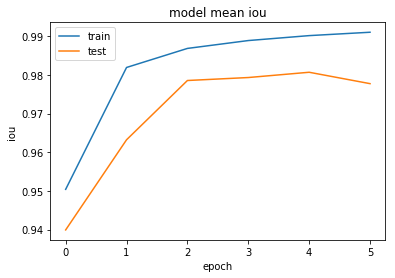

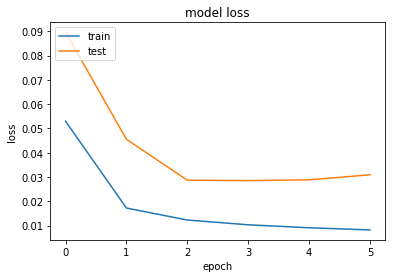

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['_mean_iou_unet_wrapper'])
plt.plot(history.history['val__mean_iou_unet_wrapper'])
plt.title('model mean iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Inference test

In [13]:
from keras.models import load_model
from utils.mrcnn_helper import show_images, resize_image
from pipeline.unet_model import _mean_iou_unet_wrapper

In [14]:
unet_infer = load_model('../pretrained_models/unet_model/unet_focal-05-0.03.hdf5', 
                        custom_objects={'_mean_iou_unet_wrapper': _mean_iou_unet_wrapper })

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
evaluation_results = unet_infer.evaluate(x=X_test, y=y_test) 

33000/33000 [==============================] - 372s 11ms/step


In [21]:
print(unet_infer.metrics_names)
print(evaluation_results)
print('loss : {}, mean iou : {}'.format(round(evaluation_results[0], 4),
                                        round(evaluation_results[1], 4)))

['loss', '_mean_iou_unet_wrapper']
[0.028840155769478192, 0.9807029495137228]
loss : 0.0288, mean iou : 0.9807


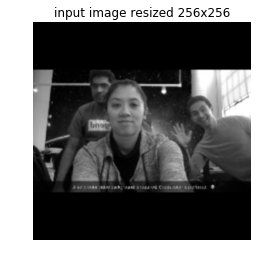

Window: (56, 0, 200, 256)


In [22]:
resize=256
image_test_path = '/home/powell/work/insight/bablu/data/images/3_carena_image.jpeg'
image_test = cv2.imread(image_test_path, cv2.IMREAD_GRAYSCALE)
image_test_resized, window, scale, padding, crop = resize_image(image_test, 
                                                                 min_dim=resize, max_dim=resize,
                                                                 mode="square")
image_test_resized = image_test_resized.reshape(256, 256, 1)
show_images([image_test_resized], ['input image resized'])
print('Window: {}'.format(window))

In [23]:
import time

In [24]:
start_time = time.time()
image_test_infer = unet_infer.predict(np.array([image_test_resized/255]))
end_time = time.time()
print('Total time: {}'.format(end_time - start_time))

Total time: 0.5735454559326172


In [25]:
image_test_infer = image_test_infer[0]

In [26]:
print(image_test_infer.shape)

(256, 256, 1)


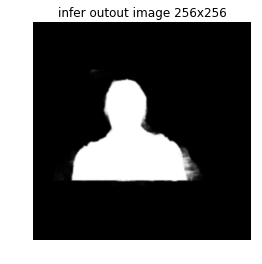

In [27]:
show_images([image_test_infer.reshape(256, 256)], ['infer outout image'])

In [28]:
w = window
mask_window = image_test_infer[w[0]:w[2], w[1]:w[3], :]

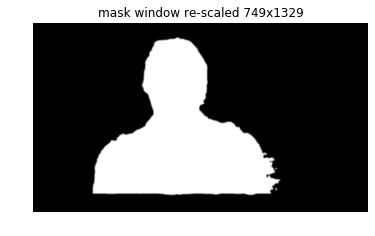

In [29]:
mask_window_orig = cv2.resize(mask_window, (image_test.shape[1], image_test.shape[0]),
                              interpolation=cv2.INTER_CUBIC)
mask_window_orig = (mask_window_orig > 0.5).astype('uint8')
show_images([mask_window_orig], ['mask window re-scaled'])

In [31]:
image_orig_path = '/home/powell/work/insight/bablu/data/images/3_carena_image.jpeg'
image_orig = cv2.cvtColor(cv2.imread(image_test_path), cv2.COLOR_BGR2RGB)

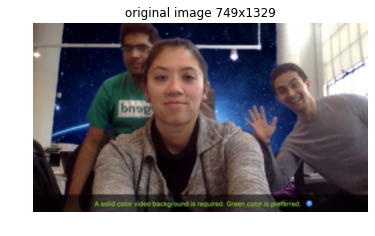

In [32]:
show_images([image_orig], ['original image'])

In [33]:
blur = cv2.blur(image_orig, (int(image_orig.shape[0]/4), int(image_orig.shape[1]/4)))

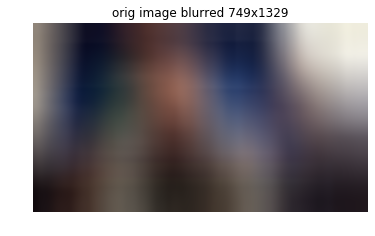

(749, 1329, 3)


In [34]:
show_images([blur], ['orig image blurred'])
print(blur.shape)

In [35]:
blur[:, :, 0] = np.where(mask_window_orig == 1, image_orig[:, :, 0], blur[:, :, 0])
blur[:, :, 1] = np.where(mask_window_orig == 1, image_orig[:, :, 1], blur[:, :, 1])
blur[:, :, 2] = np.where(mask_window_orig == 1, image_orig[:, :, 2], blur[:, :, 2])
print(blur.shape)

(749, 1329, 3)


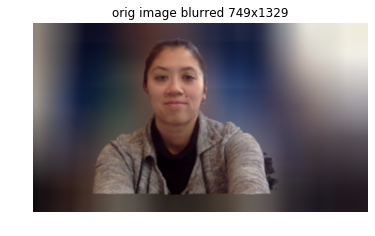

In [36]:
show_images([blur], ['original image with mask'])

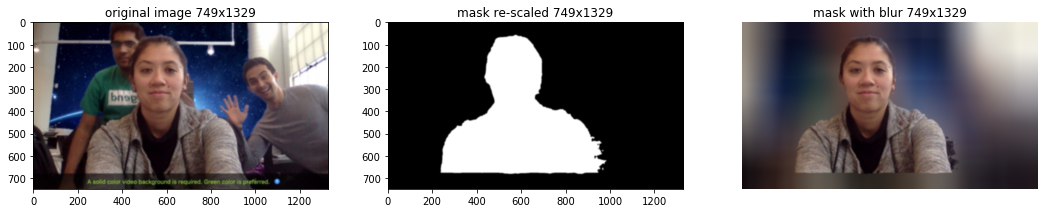

In [37]:
show_images([image_orig, mask_window_orig, blur], ['original image', 'mask re-scaled', 'mask with blur'])

In [4]:
import tensorflow as tf

converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file(
    "../pretrained_models/unet_model/unet_focal-03-0.03.hdf5", 
    custom_objects={'_mean_iou_unet_wrapper': _mean_iou_unet_wrapper })
tflite_model = converter.convert()
open("../pretrained_models/unet_model/unet_focal-03-0.03-converted_model.tflite", "wb").write(tflite_model)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 48 variables.
INFO:tensorflow:Converted 48 variables to const ops.


124137464

In [12]:
import numpy as np
import tensorflow as tf
import time

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../pretrained_models/unet_model/unet_focal-03-0.03-converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
start_time = time.time()
input_shape = input_details[0]['shape']
input_data = np.array([image_test_resized], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
end_time = time.time()
print('Total time: {}'.format(end_time - start_time))
#print(output_data)

Total time: 1.4935226440429688


(256, 256, 1)


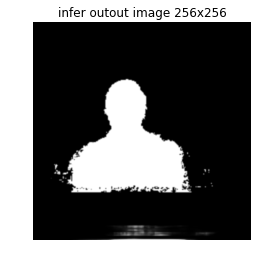

In [10]:
output_data_infer = output_data[0]
print(output_data_infer.shape)
show_images([output_data_infer.reshape(256, 256)], ['infer outout image'])